In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import threading
import mediapipe as mp

2025-05-21 23:49:53.084642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-21 23:49:53.705387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def update_path(row, base):
    return os.path.join(base, str(row['label']), row['pth'])

In [3]:
IMG_SIZE = 224
lock = threading.Lock()
train_df = pd.read_csv('raf-db/train_labels.csv')
val_df = pd.read_csv('raf-db/test_labels.csv')
train_df = train_df.rename(columns={'image': 'pth', 'label': 'label'})
val_df = val_df.rename(columns={'image': 'pth', 'label': 'label'})

train_df['pth'] = train_df.apply(lambda row: update_path(row, "DATASET/train/"), axis=1)
val_df['pth'] = val_df.apply(lambda row: update_path(row, "DATASET/test/"), axis=1)

full_df = pd.concat([train_df, val_df], ignore_index=True)

mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

I0000 00:00:1747871394.831879 3918458 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1747871394.914105 3918649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [4]:
def detect_and_crop_face(image):
    with lock:
        if image is None:
            return None
        
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detector.process(img_rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape

                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)

                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)

                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
        
        return None

In [5]:
r_hist = np.zeros(256)
g_hist = np.zeros(256)
b_hist = np.zeros(256)

for i in tqdm(range(len(full_df)), desc="Processing Images"):
    row = full_df.iloc[i]
    img_path = os.path.join('raf-db', row['pth'])
    image = cv2.imread(img_path)
    if image is None:
        continue

    face = detect_and_crop_face(image)
    if face is None:
        continue

    b, g, r = cv2.split(face)
    r_hist += np.histogram(r.flatten(), bins=256, range=(0, 256))[0]
    g_hist += np.histogram(g.flatten(), bins=256, range=(0, 256))[0]
    b_hist += np.histogram(b.flatten(), bins=256, range=(0, 256))[0]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747871394.963420 3918643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Images: 100%|██████████| 15339/15339 [03:07<00:00, 82.00it/s]


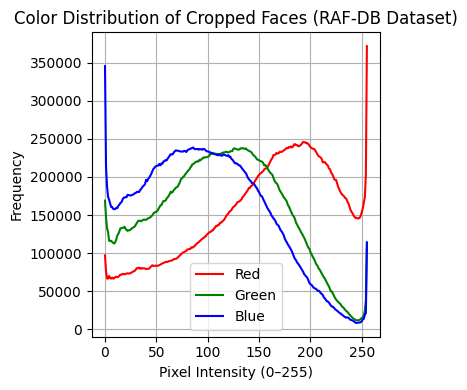

In [6]:
plt.figure(figsize=(4, 4))
plt.plot(r_hist, color='red', label='Red')
plt.plot(g_hist, color='green', label='Green')
plt.plot(b_hist, color='blue', label='Blue')
plt.title('Color Distribution of Cropped Faces (RAF-DB Dataset)')
plt.xlabel('Pixel Intensity (0–255)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
r_hist = np.zeros(256)
g_hist = np.zeros(256)
b_hist = np.zeros(256)

total_pixels = 0  

for i in tqdm(range(len(full_df)), desc="Processing Images"):
    row = full_df.iloc[i]
    img_path = os.path.join('raf-db', row['pth'])
    image = cv2.imread(img_path)
    if image is None:
        continue

    face = detect_and_crop_face(image)
    if face is None:
        continue

    b, g, r = cv2.split(face)

    r_flat = r.flatten()
    g_flat = g.flatten()
    b_flat = b.flatten()

    r_hist += np.histogram(r_flat, bins=256, range=(0, 256))[0]
    g_hist += np.histogram(g_flat, bins=256, range=(0, 256))[0]
    b_hist += np.histogram(b_flat, bins=256, range=(0, 256))[0]

    total_pixels += r_flat.size  # r, g, b are same size

# Normalize
r_hist_norm = r_hist / total_pixels
g_hist_norm = g_hist / total_pixels
b_hist_norm = b_hist / total_pixels


Processing Images: 100%|██████████| 15339/15339 [03:07<00:00, 81.80it/s]


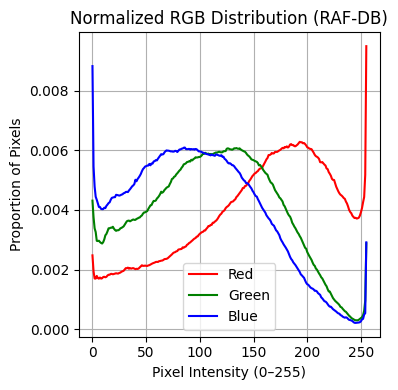

In [8]:
plt.figure(figsize=(4, 4))
plt.plot(r_hist_norm, color='red', label='Red')
plt.plot(g_hist_norm, color='green', label='Green')
plt.plot(b_hist_norm, color='blue', label='Blue')
plt.title("Normalized RGB Distribution (RAF-DB)")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Proportion of Pixels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('RAF-DB-ColorDist.png', dpi=300)
plt.show()

In [9]:
def extract_skin(image):
    """Returns a skin-segmented image and the mask."""
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lower = np.array([0, 133, 77], dtype=np.uint8)
    upper = np.array([255, 173, 127], dtype=np.uint8)
    mask = cv2.inRange(img_ycrcb, lower, upper)
    skin = cv2.bitwise_and(image, image, mask=mask)
    return skin, mask

In [10]:
# Initialize face detector
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
IMG_SIZE = 224
lock = threading.Lock()

def detect_and_crop_face(image):
    with lock:
        if image is None:
            return None
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detector.process(img_rgb)
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
                face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                return cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        return None

I0000 00:00:1747871770.189064 3918458 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1747871770.267249 3926153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [11]:
def show_skin_filter_example(image, face, skin_img, skin_mask):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Face")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(skin_img, cv2.COLOR_BGR2RGB))
    plt.title("Skin Filtered")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(skin_mask, cmap='gray')
    plt.title("Skin Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


W0000 00:00:1747871770.300125 3926148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


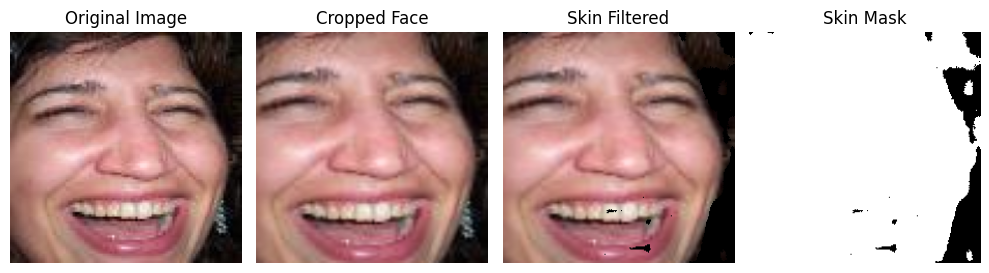

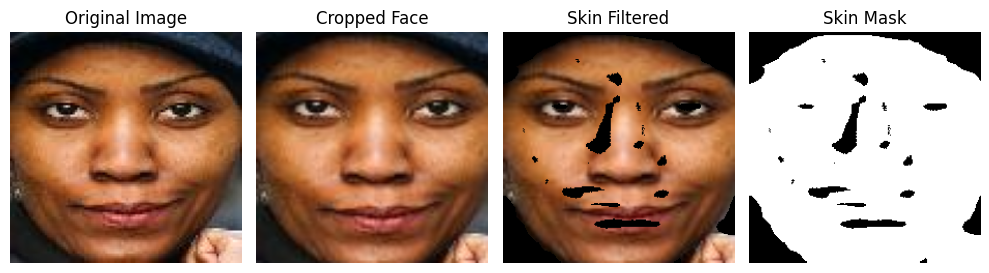

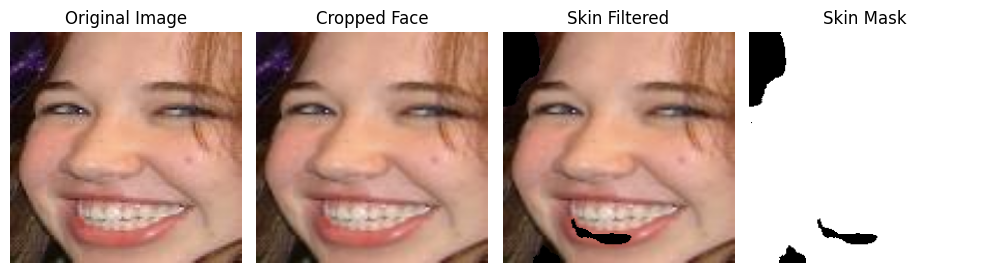

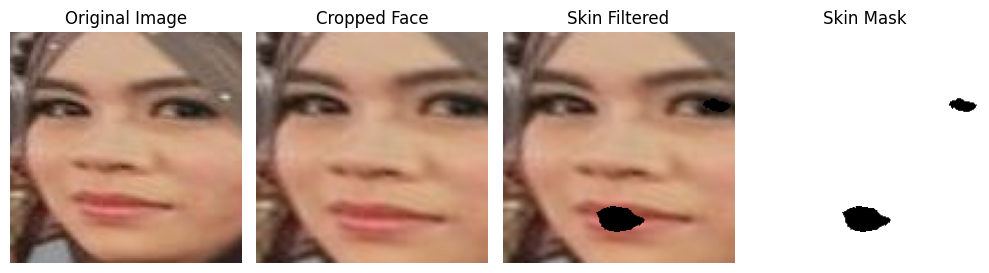

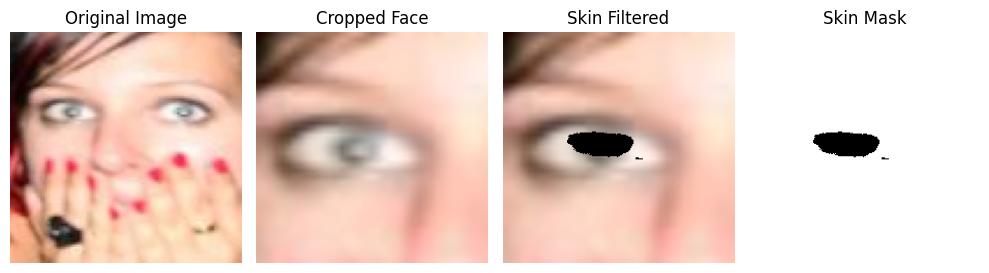

In [12]:
shown = 0
for i in range(len(full_df)):
    row = full_df.iloc[i]
    img_path = os.path.join('raf-db', row['pth'])
    image = cv2.imread(img_path)
    if image is None:
        continue

    face = detect_and_crop_face(image)
    if face is None:
        continue

    skin_img, skin_mask = extract_skin(face)

    show_skin_filter_example(image, face, skin_img, skin_mask)
    
    shown += 1
    if shown >= 5:
        break


In [13]:
all_skin_pixels = []

for i in tqdm(range(len(full_df)), desc="Extracting skin pixels (RAF-DB)"):
    row = full_df.iloc[i]
    img_path = os.path.join('raf-db', row['pth'])  # Adjust path prefix
    image = cv2.imread(img_path)
    if image is None:
        continue

    face = detect_and_crop_face(image)
    if face is None:
        continue

    skin_img, skin_mask = extract_skin(face)
    skin_pixels = skin_img[skin_mask > 0]
    
    if len(skin_pixels) > 0:
        all_skin_pixels.append(skin_pixels)

# Stack all skin pixels
all_skin_pixels = np.vstack(all_skin_pixels)

Extracting skin pixels (RAF-DB): 100%|██████████| 15339/15339 [03:06<00:00, 82.20it/s]


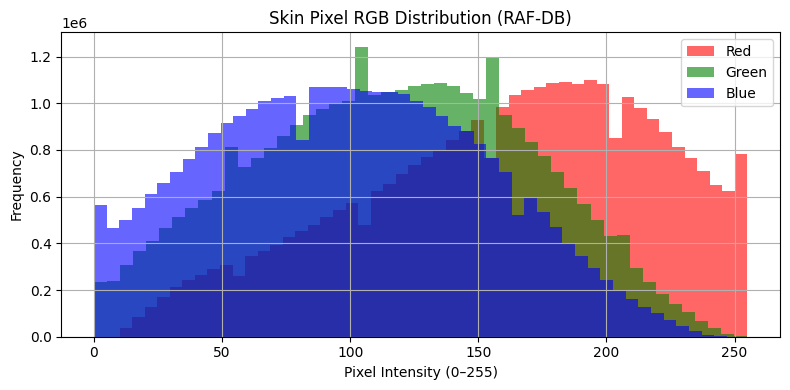

In [14]:
plt.figure(figsize=(8, 4))
plt.hist(all_skin_pixels[:, 2], bins=50, color='red', alpha=0.6, label='Red')   # R
plt.hist(all_skin_pixels[:, 1], bins=50, color='green', alpha=0.6, label='Green') # G
plt.hist(all_skin_pixels[:, 0], bins=50, color='blue', alpha=0.6, label='Blue')  # B
plt.title("Skin Pixel RGB Distribution (RAF-DB)")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()